<a href="https://colab.research.google.com/github/satomen/notebook/blob/main/satomen/notebook/main/satoshimonkeygape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Satoshi SLEAP Project - Gape CSV plot, classification


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import medfilt, savgol_filter

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
import os
os.chdir("/content/drive/My Drive/gape_t")
!ls

points3d_gape.csv  points3d_gape_smooth.csv


In [6]:
CSV_PATH = "/content/drive/My Drive/gape_t/points3d_gape.csv"

In [7]:
TIME_COL = "time_s"
GAPE_COL = "gape_mm"

df = pd.read_csv(CSV_PATH)

# basic sanity: infer sample rate from time column if present, otherwise assume 120 Hz
if TIME_COL in df.columns:
    t = df[TIME_COL].to_numpy()
    dt = np.median(np.diff(t))
    Fs = 1.0 / dt if dt > 0 else 120.0
else:
    Fs = 120.0
    t = np.arange(len(df)) / Fs

g = df[GAPE_COL].to_numpy(dtype=float)

# handle NaNs by linear interpolation (ends held constant)
if np.isnan(g).any():
    nans = np.isnan(g)
    g[nans] = np.interp(np.flatnonzero(nans), np.flatnonzero(~nans), g[~nans])

In [8]:
MED_K = 9        # median kernel (odd)
SG_WIN = 31    # Savitzky–Golay window length (odd, >= poly+2)
SG_POLY = 3      # polynomial order

# ensure valid/odd sizes
MED_K  = max(3, MED_K + (1 - MED_K % 2))
SG_WIN = max(SG_POLY + 2 + ((SG_POLY + 2) % 2 == 0), SG_WIN + (1 - SG_WIN % 2))
SG_WIN = min(SG_WIN, len(g) - (1 - len(g) % 2))  # can't exceed length; keep odd

g_med = medfilt(g, kernel_size=MED_K)
g_sg  = savgol_filter(g_med, window_length=SG_WIN, polyorder=SG_POLY)

df["gape_med{}".format(MED_K)] = g_med
df["gape_sg{}_p{}".format(SG_WIN, SG_POLY)] = g_sg

OUT_CSV = CSV_PATH.replace(".csv", "_smooth.csv")
df.to_csv(OUT_CSV, index=False)
print("Saved:", OUT_CSV, "| Fs ≈ {:.3f} Hz  (dt ≈ {:.4f} s)".format(Fs, 1/Fs))

Saved: /content/drive/My Drive/gape_t/points3d_gape_smooth.csv | Fs ≈ 120.005 Hz  (dt ≈ 0.0083 s)


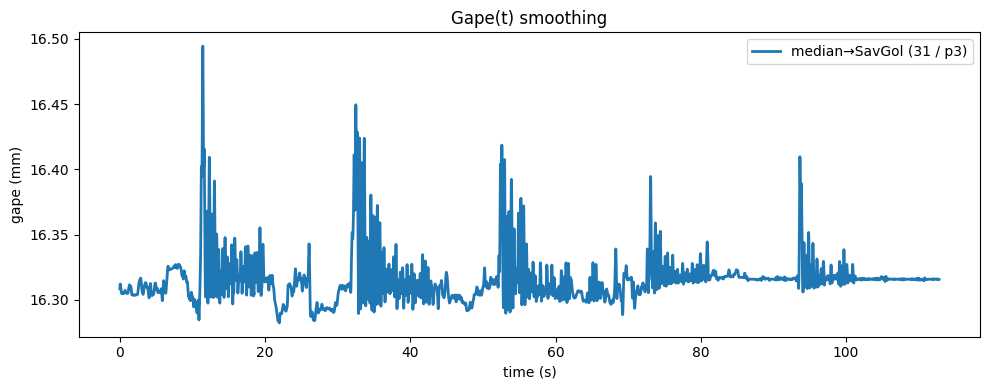

In [9]:
plt.figure(figsize=(10,4))
plt.plot(t, g_sg, lw=2, label="median→SavGol ({} / p{})".format(SG_WIN, SG_POLY))
plt.xlabel("time (s)")
plt.ylabel("gape (mm)")
plt.title("Gape(t) smoothing")
plt.legend()
plt.tight_layout()
plt.show()

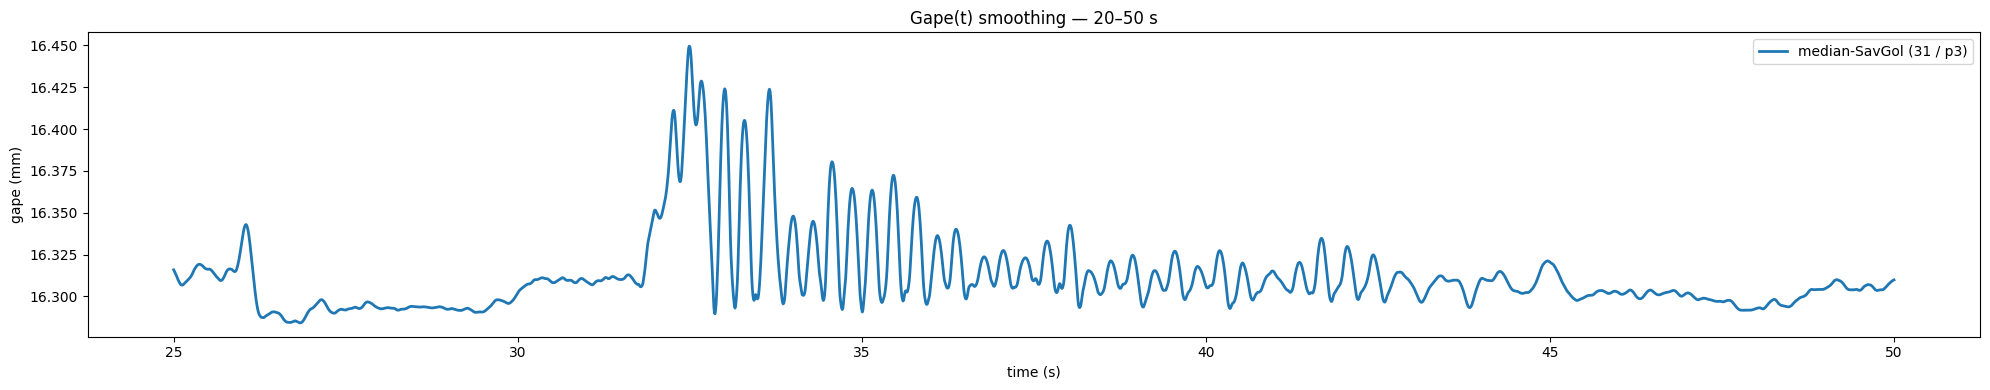

In [10]:
mask = (t >= 25.0) & (t <= 50.0)

plt.figure(figsize=(20,4))
plt.plot(t[mask], g_sg[mask], lw=2, label=f"median-SavGol ({SG_WIN} / p{SG_POLY})")
plt.xlabel("time (s)")
plt.ylabel("gape (mm)")
plt.title("Gape(t) smoothing — 20–50 s")
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
dt = float(np.median(np.diff(t)))        # sampling interval (s)
a_sg = savgol_filter(g_med, SG_WIN, SG_POLY, deriv=2, delta=dt)  # mm/s^2

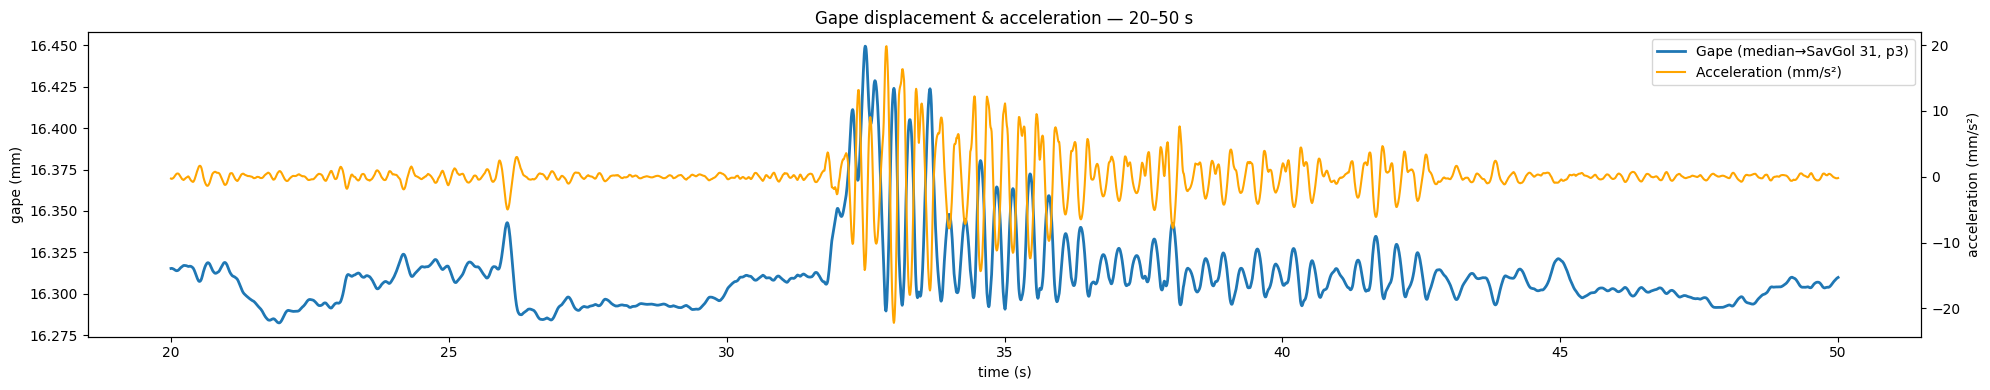

In [12]:
mask = (t >= 20.0) & (t <= 50.0)

fig, ax1 = plt.subplots(figsize=(20,4))
ax1.plot(t[mask], g_sg[mask], lw=2,
         label=f"Gape (median→SavGol {SG_WIN}, p{SG_POLY})")
ax1.set_xlabel("time (s)")
ax1.set_ylabel("gape (mm)")

ax2 = ax1.twinx()
ax2.plot(t[mask], a_sg[mask], color='orange', lw=1.5, label="Acceleration (mm/s²)")
ax2.set_ylabel("acceleration (mm/s²)")

# one legend for both axes
lines = ax1.get_lines() + ax2.get_lines()
labels = [ln.get_label() for ln in lines]
ax1.legend(lines, labels, loc="upper right")

plt.title("Gape displacement & acceleration — 20–50 s")
plt.tight_layout()
plt.show()

/tmp/ipython-input-2352170738.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


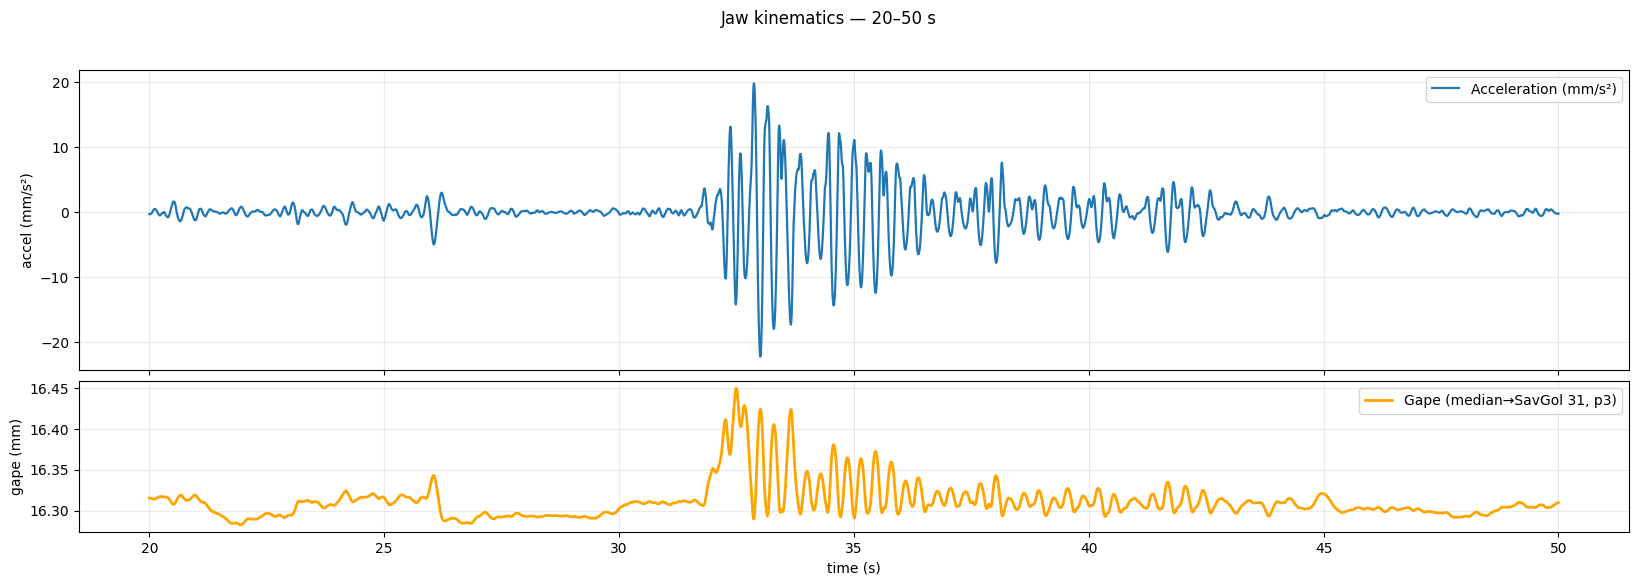

In [13]:
mask = (t >= 20.0) & (t <= 50.0)

import matplotlib.pyplot as plt
fig, (ax_top, ax_bot) = plt.subplots(
    2, 1, figsize=(20,6), sharex=True,
    gridspec_kw={"height_ratios": [2, 1], "hspace": 0.05}
)

ax_top.plot(t[mask], a_sg[mask], lw=1.6, label="Acceleration (mm/s²)")
ax_top.set_ylabel("accel (mm/s²)")
ax_top.legend(loc="upper right")
ax_top.grid(alpha=0.25)

ax_bot.plot(t[mask], g_sg[mask], lw=2, color="orange",
            label=f"Gape (median→SavGol {SG_WIN}, p{SG_POLY})")
ax_bot.set_ylabel("gape (mm)")
ax_bot.set_xlabel("time (s)")
ax_bot.legend(loc="upper right")
ax_bot.grid(alpha=0.25)

plt.suptitle("Jaw kinematics — 20–50 s", y=0.98)
plt.tight_layout()
plt.show()